# King County Housing Price Analysis
## Jonny's Location Analysis

Jonny and Tosca's phase 2 project. This notebook analyzes models built from location features and Tosca's notebook analyzes models built from home features. 

### CRISP-DM Data Science Process
Below I follow the CRISP-DM process for data science analysis. The stages of analysis that will follow below are Business Understanding, Data Understanding, Data Preparation, Modeling, and Evaluating. The final step of CRISP-DM, Deployment, will be ignored here as it is outside the scope of this project.

# Business Understanding

The goal of this analysis is to create a model that can be used by realtors in the King County area to successfully desribe how location-based and home-based features influence the price of a home relative to other features. These models seek to predict home prices and describe the linear dependancy of price on each of the features. The features come from the data we are given to complete this project. 

The stakeholders in this analysis are realtors. The intention is they use the information to understand and describe to home buyers and sellers which features of a home influence its cost.

The scope of the analysis is determined by the data. Predicting price based on features like square footage, floors, zipcode, etc is within the scope of this analysis. Predicting home prices outside the range of the data we have, e.g. outside King County, is not wihtin the scope of this analysis. For the first iteration of modeling, I have included all locations given in the data as the scope of my location analysis. There is more detail on this below.

# Data Understanding

The housing data for this project comes from Kings County, Washington. The county encompasses the  area of greater Seattle. 

In [1]:
# The usual imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
# Will be using stats models to inspect p-values for features
import statsmodels.api as sm

In [3]:
# SkLearn is how the data will be scaled, split into training and testing sets, modeled, and validated.

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [4]:
# Importing the print_metrics function created by Lindsey Berlin, stored in the functions.py file
from functions import print_metrics

In [5]:
df = pd.read_csv('data/kc_house_data.csv')

In [6]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### *Target and Predictors*

The target in the data we would like to predict is price of the home.

We have access to all the columns listed above to use as predictors. In this group project, the analysis will be broken into two parts, a model using house features as predictors (Tosca) and a model using location-based features as the predictors (Jonny). This notebook is the analysis for the latter, location based model.

I plan on focusing on using zipcode location for this model, but will also need to use other features to account for information that zipcode does not. Waterfront and the lot size of neighboring homes are features I would consider to be 'location based'. But since the majority of price of a home is determined by house and lot square footage, those columns are necessarily included. With home and lot size accounting for most of the variation in price (as they should), I want the model to clealy show how much the location predictors influence price on top of that. 

In [7]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

## *Addressing Model Assumptions*

The first step after selecting predictors is to examine the distributions of parameters to search for multicolinearity, proper scaling, and things like outliers. 

First let's plot the distributions of the location parameters we are interested in (not including the lat, long, and categoricals zipcode and waterfront).

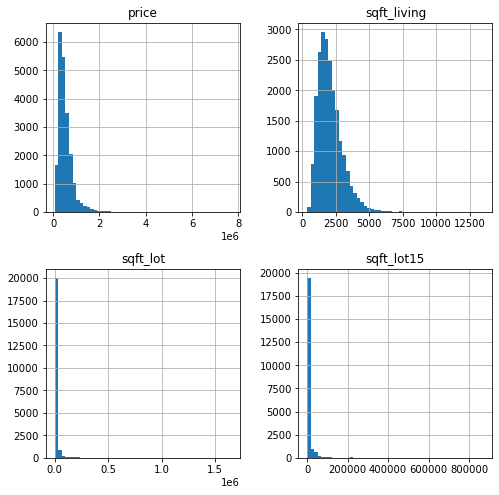

In [8]:
df.hist(column=['price', 'sqft_living', 'sqft_lot', 'sqft_lot15'], figsize=(8,8), bins=50);

All of these features are not quite normally distributed. sqft_living is the most normal but with a tail on the right. Let's see how they look if we log transform them. 

In [9]:
log_df = pd.DataFrame()
non_normal = ['price', 'sqft_living', 'sqft_lot', 'sqft_lot15']
for feat in non_normal:
    log_df['log_'+feat] = df[feat].map(lambda x: np.log(x))

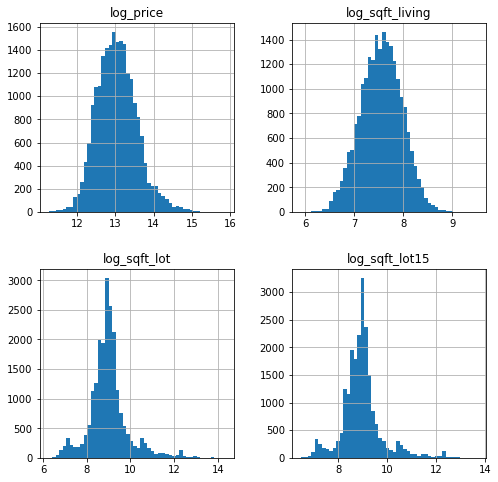

In [10]:
log_df.hist(figsize=(8,8), bins=50);

Now our features looks normally distributed. This is not an essential step, but can be used to improve the model prediction accuracy compared to using non-normal features. In my earier data exploration while comparing models I found that using raw predictor data wasn't quite hitting the desired r-squared value I wanted, and using log tranformations was able to improve r^2 by about 0.1 on average. In the end, I will need to un-transform the price target so the information is qualitative and presentable. 

### *Outliers and trimming*

Based on these histograms and other exploration, I think the data *could* be trimmed slightly. But the skews are not so bad, and if the model can still predict successfully with all data than that is obviously preferred. I would personally prefer to use log tranforming to improve the fit of the model than to remove entire zipcodes to improve fit.

#### *Are certain zipcodes outliers?*
The distributions of lot square footage above brought up the point that maybe certain zipcodes are mostly farmland and skew the sqft_lot distribution. It would be ideal to have a model that can account for this, but just in case we should find out which zipcodes those might be. Then after doing the regression, if those zipcodes didn't perform well as predictors it might be best to remove those zipcodes from th data and just try to predict home prices for similar suburbian zipcodes. Because price is the target, I am also going to look at average price per zipcode as a sanity check.

<ipython-input-11-5da81e16cba7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=zips_str, rotation=60, size=8.5)
<ipython-input-11-5da81e16cba7>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=zips_str, rotation=60, size=8.5)


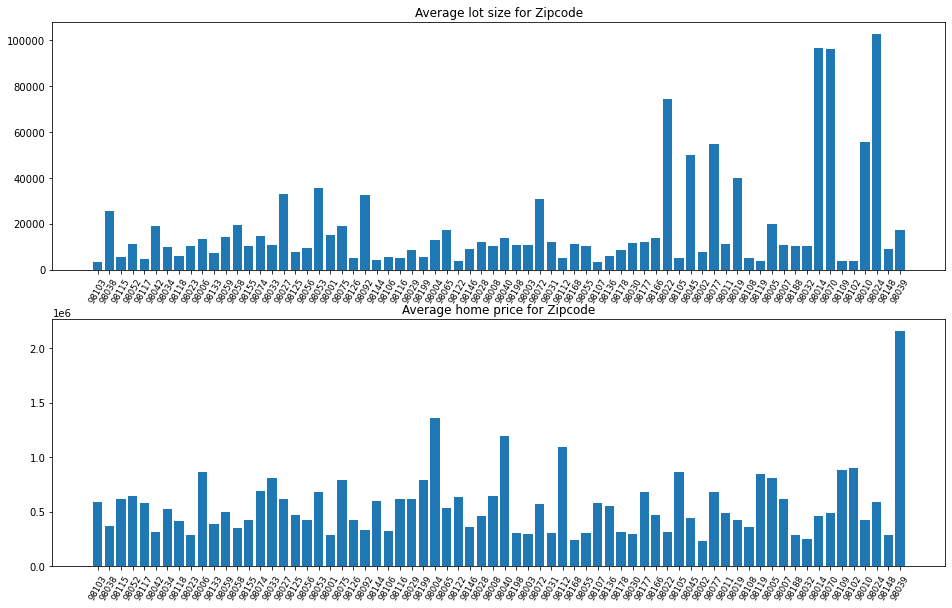

In [11]:
zips_int = list(df['zipcode'].value_counts().index)
zips_str = list(map(str, zips_int))

avg_lot = [df[df['zipcode']==z]['sqft_lot'].mean() for z in zips_int]
avg_price = [df[df['zipcode']==z]['price'].mean() for z in zips_int]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10))

ax1.bar(zips_str, avg_lot)
ax1.set_xticklabels(labels=zips_str, rotation=60, size=8.5)
ax1.set_title('Average lot size for Zipcode')

ax2.bar(zips_str, avg_price)
ax2.set_xticklabels(labels=zips_str, rotation=60, size=8.5)
ax2.set_title('Average home price for Zipcode');

It does appear that several zipcodes have significantly higher lot sizes than the others. 98022, 98014, 98070, and 98024 are the most outlier-ish. That is Enumclaw, Carnation, Vashon and Fall City respectively. These zips are the areas East of Seattle as suburbs turn to farmlands turn to mountains. Except for Vashon, which is an island southwest of downtown Seattle. 

Price seems to be fairly consistent between zipcode, save for one. 98039 is Medina, a lakeside are of Bellvue. Must be some expensive homes there. I wondered if this zip contained a lot of the waterfront properties, but as you can see in the next sub-section it does not. High housing price in this area must be due to something other than waterfront and we shouldn't have to worry about multicolinearity.

#### *Is waterfront equally distributed through zipcodes?*
There are only a few rows with waterfront == 1. Are they worth keeping around?

In [12]:
# count the number of zipcode values in a dataframe where waterfront is true
len(df[df['waterfront']==1]['zipcode'].value_counts().index)

29

So even though there are few rows with waterfront proerties (146), they are represented in 29/70 of the King County zipcodes. This is good because we now know waterfront is not colinear with a certain zipcode and we can attempt to use it as a predictor. 

Again, I would prefer a model that can explain these features as I am trying to predict based on location details. Maybe the waterfront column will help to explain some high priced outliers and leave the rest of the model to fit better. Just as I described above, my process will be to leave waterfront properties in for te first models. If it turns out they are not good predictors and hinder the rest of the model, we can go back and remove them and try to fit more constrained data. 

#### *To trim or not to trim?*
I have decided to leave in all the waterfront properties, farmland zipcodes, and high priced homes. If this model wants to learn based on location why would we want to remove all the intersting data. This was a good check to understand the features and look for subtle colinearities. If and only if the model cannot successfully predict the variance in these groups, then as in the *Evaluate* step of CRISP-DM says, I will go back and remove inconsistencies until prediction improves. This model will be referred to as the 'constrained' model.

### *Multicolinearity*

We have already explored multicolinearity in the categorical variables zipcode and waterfront above, so now let's use seaborns pairplot to look to colinearity in the continuous variables. 

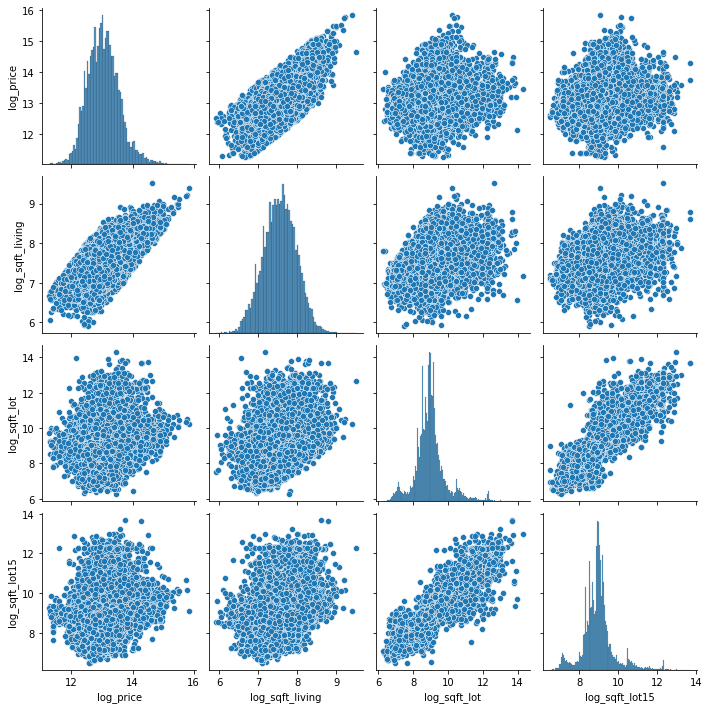

In [13]:
pair = pd.concat([log_df])
sns.pairplot(pair);

Interestingly, the square footage of the living space and lot space don't seem to be very colinear. But lot sqft and neighboring 15 lot sqft do seem to have a linear trend to them. To address this issue the columns could be combined into the ratio of the two, lot size/neighbor lot size. Values over 1 would suggest a the house's lot is larger than the average neighbors, while a value less than 1 indicates a smaller lot size than the neighbors. I like this combination as it contains a good amount of 'location' information. Rather than just lot size, we now can see this in context as lot size compared to surrounding neighbors.

### Zipcode and Lat/Long

Do deal with catgorical zipcode data in the regession, it will be one-hot encoded in the next section. I have created a dictionary to generalize zipcode areas by Seattle sub-city. For example, rather than each downtown or Bellvue area zipcode being separate, they have been grouped into areas, downtown and Bellvue each containing a few zipcodes. I have done this for ease of sharing results, and because zipcodes can tend to geographically not represent areas very well. Many zipcodes cut suburbs right down the middle. So I have opted to 'zoom out' a bit from zipcode, and combine them into larger groups where I have seen necessary.

The sub-city zipcode dictionary will be intoduced in the next section where I do the data prep, but I should mention here where I got the specific location information and maps I used to group the zipcodes. [Zipdatamaps](https://www.zipdatamaps.com/king-wa-county-zipcodes) is the link to the Kings County zipcodes and an interactive map. I used the map and my knowedge of the Seattle area to create the groups you'll find in the dictionary below.

To incorporate the Lat/Long data, I am going to create a measure of how far the home location is from the center of downtown Seattle. This metric would show if thre is a trend of home price based on proximity to downtown. There is risk of multicolinearity here with the zipcode groups, so I will check the model performance with and without this feature. If they appear to be colinear then I may create two separate models, one that uses only area and one that only uses distance to downtown and compare performance. In the next section is where I will make the transformation into a new colunmn. 


# Data Preparation

#### *Basic cleaning*

Now that the plan for how to use the data has been outlined above, below I make the actual transformations and one-hot encoding after some basic cleaning and selecting of columns.

In [14]:
# Right off the bat lets remove houses that are in the dataset twice by removing duplicated in the 'id' column
df.duplicated('id').value_counts()

False    21420
True       177
dtype: int64

In [15]:
df.drop_duplicates(subset='id', inplace=True)

There are also NaN values in the waterfront column, need to get rid of these to perform the regression. This unfortunately removes 2353 rows from the data. But waterfront is an important location factor. If it ends up not being a good predictor and it is removed, these NaN rows will be added back in to the data

In [16]:
df['waterfront'].isna().value_counts()

False    19067
True      2353
Name: waterfront, dtype: int64

In [17]:
df.dropna(subset=['waterfront'], inplace=True)

Also want to drop an outlier Tosca is removing from her data. The 33 bedroom house.

In [18]:
df = df[df['bedrooms'] < 33]

#### *Lot Ratio Column*
All three models will use the log transformed continuous features and the ratio of lot to neighbor lots, so I will first create and update those in 'df' so they all apply to the 3 dataframes created from 'df' after.

In [19]:
# Create a column that is the ratio of lot size to neighbor lot size

df['sqft_lot_ratio'] = df['sqft_lot']/df['sqft_lot15']

In [20]:
# Note that many of the homes must be in neighborhoods that must have all the exact same lot size and thus a 
# ratio of 1. Let's check exactly how many 1.

len(df[df['sqft_lot_ratio']==1]) / len(df)

0.2069128291198993

20% of the data is homes in neighborhoods with identical lot sizes. I think that 80% of the data that does have a different is enough to continue using this metric and I will move on with it.

Plot a histogram first to see if this new ratio column is one I'd like to scale or log transform.

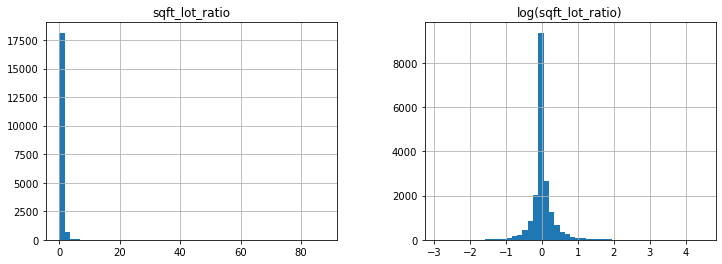

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df.hist('sqft_lot_ratio', ax = ax1, bins=50)

lg = np.log(df['sqft_lot_ratio'])
lg.hist(ax = ax2, bins=50)

ax2.set_title('log(sqft_lot_ratio)');

It's not very normal (as expected, its the ratio of two other non-normal variables). The log transformation looks like it might be a good option if we need ways to increase the coefficient of determination for the models, but it is very sharply peaked at 0 as 20% of the values are '1'.

#### *Log transforming columns*

In [22]:
# creating log transformed columns

log_feats = ['price', 'sqft_living', 'sqft_lot_ratio']
for feat in log_feats:
    df['log_'+feat] = np.log(df[feat])

### *Train Test Split*
This is the best place to split the data into training and testing sets. Doing it on the original df ensures each of the three following dataframes and models are training and testing on the same split, ensuring we can accurately evaluate and compare the models. 

In [23]:
# first split the target (y) from the predictors (X)

y_df = df['log_price']
X_df = df.drop('log_price', axis=1)
# Note I am leaving all the columns in the X_df because I select from them differently for each model.


In [24]:
# Now use sklearn to split the df into training and testing

X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(
    X_df, y_df, test_size=0.25, random_state=42)

The columns will be scaled once each dataframe is created.

### *Creating dataframes for the different models*

Since I want to compare 3 different ways to deal with location in the model, I am going to create 3 separate dataframes in order to easily do each. 

Each model will target price, and still include sqft_living, the ratio of sqft_lot to sqft_lot15 (neighbor lot), and waterfront. The difference between the dataframes and models are detailed below.

1. The first model will use zipcode and one-hot encode right from the zips listed in the data.
2. The second model generalizes the zipcodes into the different sub-cities of Seattle I have defined and then one-hot encodes them.
3. The third model will use lat/long to compute a distance from city center and use this in place of a zip location.

All three models will be compared in the results and the one that performs best will be used for analysis and to answer the business questions. I will create each of these 3 dataframes from 'df' but give them different names so they can easily by input into the linear regression functions separately. The first will be called 'zip_df' as it uses raw zipcodes. The second will be called 'kc_df' as it uses the different cities within King County instead of zipcode. The third dataframe will be called 'll_df' for the lat/long metric it uses. 

Note: as mentioned in the previous section, a 4th 'constrained' model may also be created if these three cannot successfully account for the variation.

### *Zipcode model prep*

Selecting the desired columns from X_df_train, scale them, and then one-hot encoding the zipcodes.

In [25]:
# identify the columns needed for this df
zip_cols = ['log_sqft_living', 'log_sqft_lot_ratio', 'waterfront', 'zipcode']

# create the df for this model
zip_df = X_df_train[zip_cols]

In [26]:
# use Standard Scalar to scale the two continuous columns, log_sqft_living and log_sqft_lot_ratio
# I am also using column transformer to make sure the other columns are left the same

ct = ColumnTransformer([
        ('zip_transform', StandardScaler(), ['log_sqft_living', 'log_sqft_lot_ratio'])
    ], remainder='passthrough')

zip_df_scaled = pd.DataFrame(ct.fit_transform(zip_df), columns=zip_cols)

In [27]:
zip_df_scaled.head()

,log_sqft_living,log_sqft_lot_ratio,waterfront,zipcode
0,0.211883,-0.080386,0.0,98052.0
1,0.084758,-0.080386,0.0,98040.0
2,-0.074918,-0.080386,0.0,98053.0
3,-1.034626,-1.093585,0.0,98042.0
4,0.973902,-3.933485,0.0,98006.0


In [28]:
# Here I will use Pandas get dummy variable function to encode zips

zip_dummies = pd.get_dummies(zip_df_scaled['zipcode'], prefix='zip', drop_first=True)
zip_normals = zip_df_scaled.drop('zipcode', axis=1)
zip_X_train_scaled = pd.concat([zip_normals, zip_dummies], axis=1)
zip_X_train_scaled.head()

,log_sqft_living,log_sqft_lot_ratio,waterfront,zip_98002.0,zip_98003.0,zip_98004.0,zip_98005.0,zip_98006.0,zip_98007.0,zip_98008.0,...,zip_98146.0,zip_98148.0,zip_98155.0,zip_98166.0,zip_98168.0,zip_98177.0,zip_98178.0,zip_98188.0,zip_98198.0,zip_98199.0
0,0.211883,-0.080386,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.084758,-0.080386,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.074918,-0.080386,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.034626,-1.093585,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.973902,-3.933485,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The same thing needs to be done to the X_test data

In [29]:
# Select columns for test
zip_df_test = X_df_test[zip_cols]

# Transform it using the scaler fit to the training data
zip_df_test_scaled = pd.DataFrame(ct.transform(zip_df_test), columns=zip_cols)

# Then create the same dummy variables as above
zip_dummies_test = pd.get_dummies(zip_df_test_scaled['zipcode'], prefix='zip', drop_first=True)
zip_normals_test = zip_df_test_scaled.drop('zipcode', axis=1)
zip_X_test_scaled = pd.concat([zip_normals_test, zip_dummies_test], axis=1)

The zip_X_train dateframe is now ready to be train/test split and input to regression along with the target y_df_train which will be the same for all models.

### *City model prep*

For the city/suburb model I have created a dictionary to attach city labels to zipcodes. Initialize it below.

In [30]:
 suburb_dict = {
               'Auburn': [98001, 98002, 98092],
               'Ballard': [98117, 98107],
               'Baring': [98224],
               'Bellevue': [98004, 98005, 98006, 98007, 98008],
               'Black Diamond': [98010],
               'Bothell': [98011],
               'Broadview': [98177, 98133],
               'Buckley': [98321],
               'Burien': [98146, 98148, 98166, 98168],
               'Capital Hill': [98102, 98112],
               'Carnation': [98014],
               'Cle Elum': [98922],
               'Covington': [98042],
               'Delridge': [98106],
               'Des Moines': [98198],
               'Duvall': [98019],
               'Enumclaw': [98022],
               'Fall City': [98024],
               'Federal Way': [98003],
               'Gold Bar': [98251],
               'Greenwood': [98103],
               'Issaquah': [98027, 98029],
               'Kenmore': [98028],
               'Kent': [98030, 98031, 98032],
               'Kirkland': [98033, 98034],
               'Lake City': [98125],
               'Lake Forest Park': [98155],
               'Leavenworth': [98826],
               'Madrona': [98122],
               'Magnolia': [98199],
               'Maple Valley': [98038],
               'Medina': [98039],
               'Mercer Island': [98040],
               'Milton': [98054],
               'Mount Baker': [98144],
               'North Bend': [98045],
               'Northeast Seattle': [98115],
               'Pacific': [98047],
               'Ravensdale': [98051],
               'Rainier Valley': [98108, 98118],
               'Redmond': [98052, 98053],
               'Renton': [98055, 98056, 98057, 98058, 98059, 98178],
               'Sammamish': [98074, 98075],
               'Seattle': [98134, 98101, 98104, 98121, 98131, 98132, 98154, 98158, 98561, 98164, 98174],
               'Skyomish': [98288],
               'Snoqualmie': [98065],
               'Tukwila': [98188],
               'Queen Anne': [98119, 98109],
               'University': [98105, 98195],
               'Vashon': [98070],
               'West Seattle': [98116, 98126, 98136],
               'Woodinville': [98072]
               }

In [31]:
pd.options.mode.chained_assignment = None

In [32]:
kc_cols = ['log_sqft_living', 'log_sqft_lot_ratio', 'waterfront', 'zipcode']
kc_df_train = X_df_train[kc_cols]

for key, values in suburb_dict.items():
    kc_df_train[key] = kc_df_train['zipcode'].map(lambda x: 1 if (x in values) else 0)
    
kc_df_train.drop('zipcode', axis=1, inplace=True)

Let's check and see how many rows are in each King County city

In [33]:
sub = [key for key, value in suburb_dict.items()]

for s in sub:
    ct = len(kc_df_train[kc_df_train[s]==1])
    print(s, ct)

Auburn 613
Ballard 543
Baring 0
Bellevue 955
Black Diamond 68
Bothell 134
Broadview 483
Buckley 0
Burien 564
Capital Hill 253
Carnation 84
Cle Elum 0
Covington 351
Delridge 216
Des Moines 175
Duvall 121
Enumclaw 157
Fall City 55
Federal Way 181
Gold Bar 0
Greenwood 415
Issaquah 492
Kenmore 189
Kent 433
Kirkland 663
Lake City 262
Lake Forest Park 278
Leavenworth 0
Madrona 188
Magnolia 215
Maple Valley 386
Medina 33
Mercer Island 186
Milton 0
Mount Baker 224
North Bend 143
Northeast Seattle 371
Pacific 0
Ravensdale 0
Rainier Valley 453
Redmond 648
Renton 1229
Sammamish 522
Seattle 0
Skyomish 0
Snoqualmie 223
Tukwila 82
Queen Anne 200
University 159
Vashon 78
West Seattle 641
Woodinville 175


There are multiple areas I have defined that do not have zips included in this data. Gold Bar, Cle Elum, Leavenworth, Buckley, and Milton all have zero entries; but the all have King County as a 'secondary county', so removing them has no consequence. Skyomish, Ravesdale, Baring, Pacific, and Downtown Seattle also have no entries, but King County is their primary county. 

Removing all these wont have an effect on the model, but I will do it for cleanliness. Removing the suburbs that strictly are part of King County does have an effect on the scope of this model. I can no longer say it can predit home price across the entire county. There is no data for downtown Seattle, and the eastern rural areas of Kings County (of which Snoqualmie, Ravensdale, Baring, Pacific are part of) are underepresented in the data compared to their portion of King County. This is a limitation that will effect how we predict the prices in the similar rural counties like Woodinville and Snoqualmie. This limitation makes a case for using the constrained model and removing all counties with large rural properties and just focusing on suburban King County/Seattle. We wont be able to as confidently predict the price of rural homes within the entire desired scope of the analysis. But we can at least try first. So rural counties that do have data will be left in, but if they do not perform well as predictors, we will try the constrained model.

Below we delete the subrubs that contain zero data points.

In [34]:
to_del = ['Gold Bar', 'Cle Elum', 'Leavenworth', 'Buckley', 'Milton', 'Skyomish', 'Ravensdale', 'Baring', 'Pacific', 'Seattle']

for d in to_del:
    suburb_dict.pop(d)

In [35]:
# and recreate the kc_df without empty regions, for both training and testing sets
kc_X_train = X_df_train[kc_cols]
kc_X_test = X_df_test[kc_cols]

# one hot encode with updated dictionary, both training and testing sets
for key, values in suburb_dict.items():
    kc_X_train[key] = kc_X_train['zipcode'].map(lambda x: 1 if (x in values) else 0)
    
for key, values in suburb_dict.items():
    kc_X_test[key] = kc_X_test['zipcode'].map(lambda x: 1 if (x in values) else 0)
    
    
kc_X_train.drop('zipcode', axis=1, inplace=True)
kc_X_test.drop('zipcode', axis=1, inplace=True)

In [36]:
kc_X_train.head()

,log_sqft_living,log_sqft_lot_ratio,waterfront,Auburn,Ballard,Bellevue,Black Diamond,Bothell,Broadview,Burien,...,Redmond,Renton,Sammamish,Snoqualmie,Tukwila,Queen Anne,University,Vashon,West Seattle,Woodinville
14061,7.644919,0.000000,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2795,7.590852,0.000000,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21015,7.522941,0.000000,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10094,7.114769,-0.362488,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20580,7.969012,-1.378506,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now to scale these training and testing sets. We unfortunately can't use the same transformer object we created above since the dataframe has conflicting remainder columns, even if the ones we are interested in scaling are the same. So instantiate a new column transformer for the kc df.

In [37]:
ct_kc = ColumnTransformer([
        ('kc_transform', StandardScaler(), ['log_sqft_living', 'log_sqft_lot_ratio'])
    ], remainder='passthrough')

kc_X_train_scaled = pd.DataFrame(ct_kc.fit_transform(kc_X_train), columns=list(kc_X_train.columns))
kc_X_test_scaled = pd.DataFrame(ct_kc.transform(kc_X_test), columns=list(kc_X_test.columns))

Okay, now the King County cities dataframe is ready.

### *Lat/Long model prep*

In place of zipcode or area, this model computes the distance the home is from Seattle city center based on the given Latitude and Longitude. I am trying this to see if proximity to downtown has an influence on price.

To easily compute a distance in miles from the lat/longs I am using GeoPy package's geodesic distance function.

In [38]:
import geopy.distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.geodesic(coords_1, coords_2).miles)

173.5818455248231


For Seattle city center, I have decided to use the coordinates for Pikes Place Market, a main attraction in the very center of the downtown.

In [39]:
seattle_ll = (47.6097, -122.3422)

In [40]:
# Use apply and map functions to create lat/long column and then proximity column using the geopy function
# Do for both training and testing
ll_X_train = X_df_train # better practice to not manipulate our original train df
ll_X_test = X_df_test

ll_X_train['ll'] = ll_X_train.apply(lambda x: (x['lat'], x['long']), axis=1)
ll_X_train['prox'] = ll_X_train['ll'].map(lambda x: geopy.distance.geodesic(seattle_ll, x).miles)

ll_X_test['ll'] = ll_X_test.apply(lambda x: (x['lat'], x['long']), axis=1)
ll_X_test['prox'] = ll_X_test['ll'].map(lambda x: geopy.distance.geodesic(seattle_ll, x).miles)

In [41]:
ll_X_train['log_prox'] = np.log(ll_X_train['prox'])

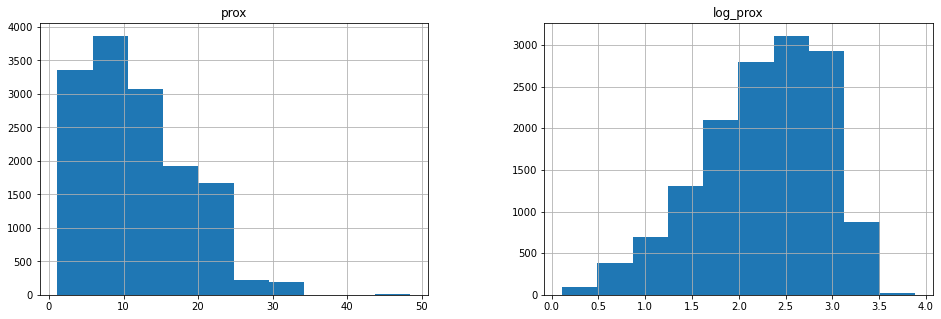

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ll_X_train.hist('log_prox', ax=ax2)
ll_X_train.hist('prox', ax=ax1);

Taking the log of the proximity doesnt make this feature look more normal. I will use the normal distance in miles for the linear model.

In [43]:
# define the columns to be used in the lat/long model. Same original 3 plus the prox

ll_cols = ['log_sqft_living', 'log_sqft_lot_ratio', 'waterfront', 'prox']

ll_X_train = ll_X_train[ll_cols]
ll_X_test = ll_X_test[ll_cols]

In [44]:
# now column transform to scale features

ct_ll = ColumnTransformer([
        ('ll_transform', StandardScaler(), ['log_sqft_living', 'log_sqft_lot_ratio', 'prox'])
    ], remainder='passthrough')

ll_X_train_scaled = pd.DataFrame(ct_ll.fit_transform(ll_X_train), columns=list(ll_X_train.columns))
ll_X_test_scaled = pd.DataFrame(ct_ll.transform(ll_X_test), columns=list(ll_X_test.columns))

Looks good, this dataframe is ready for modeling.

## Modeling

### *FSM*

Begin with setting the baseline model. 

In [45]:
baseline = y_df_train.mean()

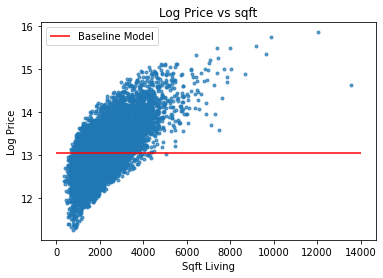

In [46]:
plt.scatter(X_df_train['sqft_living'], y_df_train, alpha=0.7, marker='.')
plt.hlines(baseline, -1, 14000, color='r', label='Baseline Model')
plt.title('Log Price vs sqft')
plt.xlabel('Sqft Living')
plt.ylabel('Log Price')
plt.legend();


In [47]:
baselines = [baseline for x in range(len(y_df_test))]

r2_baseline = r2_score(y_df_test, baselines)
print(f"Baseline R-squared: {r2_baseline:.3f}")
print(f"Baseline RMSE: {mean_squared_error(y_df_test, baselines, squared=False):.3f}")

Baseline R-squared: -0.001
Baseline RMSE: 0.522


The FSM naive model predicts the average price across all homes. The coefficient of determination for the FSM is below zero. Hopefully we can do better than that. 

### *Zipcode Model*

In [48]:
y_df_train.reset_index(drop=True, inplace=True)
y_df_test.reset_index(drop=True, inplace=True)

In [49]:
X = zip_X_train_scaled
# scaling messed with index so we need to reset y so they match
y = y_df_train

model_zipcode = sm.OLS(y, sm.add_constant(X))

results_zipcode = model_zipcode.fit()

results_zipcode.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     997.8
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:51:56   Log-Likelihood:                 1671.4
No. Observations:               14299   AIC:                            -3197.
Df Residuals:                   14226   BIC:                            -2644.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.5251      0.014    887.384      0.000      12.497      12.553
log_sqft_living        0.3083      0.002    151.708      0.000       0.304       0.312
log_sqft_lot_ratio     0.0174      0.002      9.499      0.000       0.014       0.021
waterfront             0.8085      0.022     37.267      0.000       0.766       0.851
zip_98002.0           -0.0348      0.023     -1.484      0.138      -0.081       0.011
zip_98003.0            0.0487      0.021      2.280      0.023       0.007       0.091
zip_98004.0            1.2430      0.021     60.477      0.000       1.203       1.283
zip_98005.0            0.8320      0.024     34.358      0.000       0.785       0.879
zip_98006.0            0.7964      0.018     43.267      0.000       0.760       0.832
zip_98007.0            0.7288      0.027     27.429      0.000       0.677       0.781
zip_98008.0            0.6827      0.021     32.223      0.000       0.641       0.724
zip_98010.0            0.3244      0.030     10.910      0.000       0.266       0.383
zip_98011.0            0.4636      0.023     19.814      0.000       0.418       0.509
zip_98014.0            0.4029      0.027     14.674      0.000       0.349       0.457
zip_98019.0            0.3432      0.024     14.195      0.000       0.296       0.391
zip_98022.0            0.1537      0.022      6.900      0.000       0.110       0.197
zip_98023.0           -0.0057      0.018     -0.306      0.760      -0.042       0.031
zip_98024.0            0.4858      0.032     15.019      0.000       0.422       0.549
zip_98027.0            0.5829      0.019     30.234      0.000       0.545       0.621
zip_98028.0            0.4257      0.021     20.165      0.000       0.384       0.467
zip_98029.0            0.6623      0.020     32.652      0.000       0.623       0.702
zip_98030.0            0.0373      0.022      1.695      0.090      -0.006       0.080
zip_98031.0            0.0784      0.021      3.675      0.000       0.037       0.120
zip_98032.0           -0.0146      0.027     -0.542      0.588      -0.068       0.038
zip_98033.0            0.8650      0.019     45.718      0.000       0.828       0.902
zip_98034.0            0.5832      0.018     32.313      0.000       0.548       0.619
zip_98038.0            0.1851      0.018     10.348      0.000       0.150       0.220
zip_98039.0            1.5253      0.040     37.876      0.000       1.446       1.604
zip_98040.0            1.0397      0.021     48.735      0.000       0.998       1.082
zip_98042.0            0.0947      0.018      5.198      0.000       0.059       0.130
zip_98045.0            0.3919      0.023     17.107      0.000       0.347       0.437
zip_98052.0            0.6895      0.018     38.327      0.000       0.654       0.725
zip_98053.0            0.6582      0.0

Checking the p-value column for accuracy of the predictors we can see that certain zipcodes do not describe the variance in their data. These zipcodes are 98002 (Auburn area), 98003, 98023 (both in Federal Way area), and 98032 (a Kent zip). 

I will now use an SkLearn linear regression model to see how we performed on the testing set.

In [50]:
# model
zip_model_sk = LinearRegression()

zip_model_sk.fit(zip_X_train_scaled, y_df_train)


# predictions
train_preds_zip = zip_model_sk.predict(zip_X_train_scaled)
test_preds_zip = zip_model_sk.predict(zip_X_test_scaled)

In [51]:
print(f"Train R2 Score: {r2_score(y_df_train, train_preds_zip):.3f}")
print(f"Test R2 Score: {r2_score(y_df_test, test_preds_zip):.3f}")
print("-----")
print(f"Train RMSE: {mean_squared_error(y_df_train, train_preds_zip, squared=False)}")
print(f"Test RMSE: {mean_squared_error(y_df_test, test_preds_zip, squared=False)}")

Train R2 Score: 0.835
Test R2 Score: 0.833
-----
Train RMSE: 0.21527677263472322
Test RMSE: 0.21301001725885346


In [52]:
# Use the print metrics function kindly provided by Lindsey to see the RMSE in terms of $$ and not log($)
print_metrics(y_df_train, train_preds_zip, y_df_test, test_preds_zip, log=True)

Training Scores
----------
R2: 0.8347
RMSE: 169877.4533
MAE: 90838.7177

**********
Testing Scores
----------
R2: 0.8331
RMSE: 149950.1199
MAE: 86026.3696


The model fits very well, but a RMSE of 147 thousand dollars is very high in context, if we wish to use this model for real price predictions on single homes. 

### *KC Model*

In [53]:
X = kc_X_train_scaled
y = y_df_train

model_kc = sm.OLS(y, sm.add_constant(X))

results_kc = model_kc.fit()

results_kc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1305.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:51:56   Log-Likelihood:                 476.34
No. Observations:               14299   AIC:                            -860.7
Df Residuals:                   14253   BIC:                            -512.5
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.6868      0.011   1157.198      0.000      12.665      12.708
log_sqft_living        0.3233      0.002    149.633      0.000       0.319       0.328
log_sqft_lot_ratio     0.0146      0.002      7.353      0.000       0.011       0.019
waterfront             0.7886      0.023     33.635      0.000       0.743       0.835
Auburn                -0.1345      0.014     -9.278      0.000      -0.163      -0.106
Ballard                0.7035      0.015     47.036      0.000       0.674       0.733
Bellevue               0.7007      0.013     52.484      0.000       0.675       0.727
Black Diamond          0.1620      0.030      5.318      0.000       0.102       0.222
Bothell                0.2977      0.023     12.932      0.000       0.253       0.343
Broadview              0.3864      0.015     25.227      0.000       0.356       0.416
Burien                 0.0749      0.015      5.053      0.000       0.046       0.104
Capital Hill           0.9610      0.018     52.311      0.000       0.925       0.997
Carnation              0.2421      0.028      8.697      0.000       0.188       0.297
Covington             -0.0653      0.017     -3.920      0.000      -0.098      -0.033
Delridge               0.1942      0.019      9.981      0.000       0.156       0.232
Des Moines            -0.0544      0.021     -2.606      0.009      -0.095      -0.013
Duvall                 0.1783      0.024      7.440      0.000       0.131       0.225
Enumclaw              -0.0018      0.022     -0.085      0.933      -0.044       0.041
Fall City              0.3237      0.033      9.676      0.000       0.258       0.389
Federal Way           -0.1108      0.021     -5.379      0.000      -0.151      -0.070
Greenwood              0.6983      0.016     43.757      0.000       0.667       0.730
Issaquah               0.4514      0.015     29.648      0.000       0.422       0.481
Kenmore                0.2632      0.020     12.986      0.000       0.223       0.303
Kent                  -0.1155      0.016     -7.340      0.000      -0.146      -0.085
Kirkland               0.5455      0.014     38.291      0.000       0.518       0.573
Lake City              0.4172      0.018     22.910      0.000       0.382       0.453
Lake Forest Park       0.2855      0.018     15.971      0.000       0.250       0.320
Madrona                0.7016      0.020     34.486      0.000       0.662       0.741
Magnolia               0.7717      0.019     39.812      0.000       0.734       0.810
Maple Valley           0.0212      0.016      1.310      0.190      -0.011       0.053
Medina                 1.3418      0.042     31.689      0.000       1.259       1.425
Mercer Island          0.8643      0.020     42.241      0.000       0.824       0.904
Mount Baker            0.5469      0.0

Looking at the p-value row, we can see that everything predicted well except for the Enumclaw and Maple Valley areas.

In [54]:
# Here I instantiate a Sklearn model for the KC data, in order to grab predictions later.

kc_model_sk = LinearRegression()

kc_model_sk.fit(kc_X_train_scaled, y_df_train)

train_preds_kc = kc_model_sk.predict(kc_X_train_scaled)

### *Lat/Long Model*

In [55]:
X = ll_X_train_scaled
y = y_df_train

model_prox = sm.OLS(y, sm.add_constant(X))

results_prox = model_prox.fit()

results_prox.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     6738.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:51:56   Log-Likelihood:                -3621.6
No. Observations:               14299   AIC:                             7253.
Df Residuals:                   14294   BIC:                             7291.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.0482      0.003   4986.235      0.000      13.043      13.053
log_sqft_living        0.3770      0.003    142.110      0.000       0.372       0.382
log_sqft_lot_ratio     0.0079      0.003      3.006      0.003       0.003       0.013
waterfront            -0.2262      0.003    -85.889      0.000      -0.231      -0.221
prox                   0.7096      0.031     23.042      0.000       0.649       0.770
==============================================================================
Omnibus:                      102.328   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.461
Skew:                          -0.105   Prob(JB):                     2.33e-30
Kurtosis:                       3.430   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The lat/long proximity model did not fit the data as well at using zipcode. According to this, the price of a home actually increases with distance from Seattle center. I think this model failed becasue of how large and intricate the area surrounding Seattle is. A city with a more well definied center and suburbs extended may be described by a proximity like this; but for Seattle the true description of how proximity to various areas of interest is likely much more complicated.

In the evaluate/analysis I will look at just the zipcode and KC models and ignore the lat/long results as they are not of much interest anymore.

# Evaluation

I will begin evaluating by commenting on the scope of this regression analysis. The KC and Zipcode models were both able to explain above 80% of the variance in the training and tesing sets. This gives me confidence that analyzing and comparing the magnitude of effects of different predictors can correctly tell us trends accross the entire dataset. We can report to stakeholders on which location features have the biggest influence on price.

But if we (or the stakeholders) want to use this model to predict the price of a single home, that is outside the scope of this model. While it was able to explain the variance of the data accorss the whole set well, when testing very specific subsets or single houses with these model parameters, we are not able to predict with much accuracy. We can see this initially from the RMSE reported in dollars; 150k is a large error and significant fraction of the majority of houses in the data. This will also be shown in detail below in the 'model fit for top-tier vs affordable homes' section. To improve model prediction accuracy to a degree that it could be used to predict home prices in a way like the app Zillow does, we would need to create different models for different tiers of homes and group and train them accordingly.

### *Checking Normality Assumption*

One of the first things I want to confirm in model evaluation is that the residuals for the model are normally distributed. This is an assumption of any linear model and it needs to be checked before moving forward. I will plot the residuals for both the KC model and the zipcode model.

In [56]:
# Note: I will use the residuals for the training dataset
residuals_zip = y_df_train - train_preds_zip
residuals_kc = y_df_train - train_preds_kc

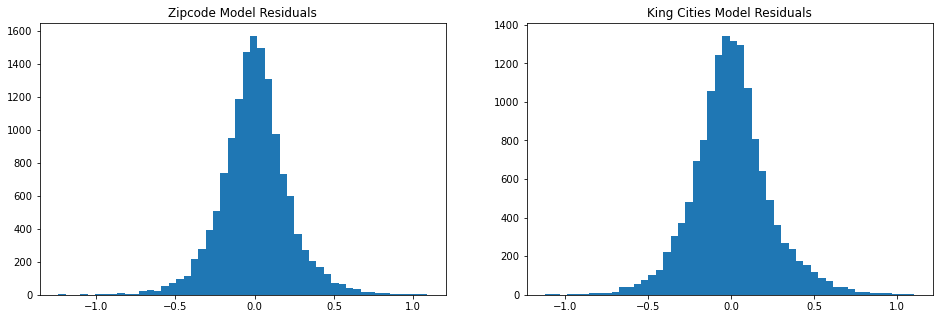

In [57]:
# Now plot the distribution of residuals for each model.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.hist(residuals_zip, bins=50)
ax1.set_title('Zipcode Model Residuals')

ax2.hist(residuals_kc, bins=50)
ax2.set_title('King Cities Model Residuals');

Awesome, the residuals for the two successful models are disributed very normally. We can also confirm this with a qq plot as shown below.

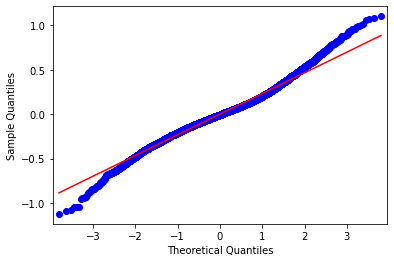

In [58]:
fig = sm.qqplot(residuals_kc, line = 'r')

In the qq plots, it is easier to see that towards the tails of the data, the data residuals become slightly less normal. But the majority of the data surrounding the center is very normal, certainly enough to move forward with analyzing these models. 

## *Coefficient and Feature Evaluation*

To evaluate the effect of different locations on price, I am going to examine the coefficients and p-values for the KC model above. I am going to use this one because I think resporting results by area is easier and more meaningful than zipcode, and because only two areas predicted with p-values above 0.05, while many more zipcodes had high p-values I would have to sort out. The zipcode model may have fit slightly better (r^2 of 0.835), but the fit of the King County cities model was still good itself and very close to the same fit (r^2 of 0.805). 

I will print the results summary for the KC model again below so coefficients can be easily looked up

In [59]:
results_kc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1305.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:51:57   Log-Likelihood:                 476.34
No. Observations:               14299   AIC:                            -860.7
Df Residuals:                   14253   BIC:                            -512.5
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.6868      0.011   1157.198      0.000      12.665      12.708
log_sqft_living        0.3233      0.002    149.633      0.000       0.319       0.328
log_sqft_lot_ratio     0.0146      0.002      7.353      0.000       0.011       0.019
waterfront             0.7886      0.023     33.635      0.000       0.743       0.835
Auburn                -0.1345      0.014     -9.278      0.000      -0.163      -0.106
Ballard                0.7035      0.015     47.036      0.000       0.674       0.733
Bellevue               0.7007      0.013     52.484      0.000       0.675       0.727
Black Diamond          0.1620      0.030      5.318      0.000       0.102       0.222
Bothell                0.2977      0.023     12.932      0.000       0.253       0.343
Broadview              0.3864      0.015     25.227      0.000       0.356       0.416
Burien                 0.0749      0.015      5.053      0.000       0.046       0.104
Capital Hill           0.9610      0.018     52.311      0.000       0.925       0.997
Carnation              0.2421      0.028      8.697      0.000       0.188       0.297
Covington             -0.0653      0.017     -3.920      0.000      -0.098      -0.033
Delridge               0.1942      0.019      9.981      0.000       0.156       0.232
Des Moines            -0.0544      0.021     -2.606      0.009      -0.095      -0.013
Duvall                 0.1783      0.024      7.440      0.000       0.131       0.225
Enumclaw              -0.0018      0.022     -0.085      0.933      -0.044       0.041
Fall City              0.3237      0.033      9.676      0.000       0.258       0.389
Federal Way           -0.1108      0.021     -5.379      0.000      -0.151      -0.070
Greenwood              0.6983      0.016     43.757      0.000       0.667       0.730
Issaquah               0.4514      0.015     29.648      0.000       0.422       0.481
Kenmore                0.2632      0.020     12.986      0.000       0.223       0.303
Kent                  -0.1155      0.016     -7.340      0.000      -0.146      -0.085
Kirkland               0.5455      0.014     38.291      0.000       0.518       0.573
Lake City              0.4172      0.018     22.910      0.000       0.382       0.453
Lake Forest Park       0.2855      0.018     15.971      0.000       0.250       0.320
Madrona                0.7016      0.020     34.486      0.000       0.662       0.741
Magnolia               0.7717      0.019     39.812      0.000       0.734       0.810
Maple Valley           0.0212      0.016      1.310      0.190      -0.011       0.053
Medina                 1.3418      0.042     31.689      0.000       1.259       1.425
Mercer Island          0.8643      0.020     42.241      0.000       0.824       0.904
Mount Baker            0.5469      0.0

It is important to note here that the constant is quite large compared to any coefs. I think much of the price that would otherwise be described by home features that I am not using in this model, is contained in the constant. 

#### *Home size and lot size*
The first piece of analysis to note from the results above, is how much price is influenced by home square footage compared to relartive lot size. Size of the home accounts for a much greater portion of the price than having a yard larger than your neighbor. Going up one standard deviation in price increases price by a factor of 0.3233 while going up one STD in lot ratio increases price by a factor of 0.0146. In future models it may be better to just use lot square footage instead of ratio to neighbor lot size.

#### *Area and location*


The main focus of this model was to try to extract infromation about how different area effect price. We can do that best be comparing the coefficients for different areas. 

First, we identify that coefficents for Enumclaw and Maple Valley have high p-values, eg. there is a high chance these values are due to randomness. We therefore note these areas coefficients will not be considered or interpreted as results.


![bar coef](images/bar_coef_KC.png)

Second, an obvious distinction we can make using the coefficients is if they are positive or negative. Negative coefficents mean that being associated with that area might actually decrease the value of the home.

The areas that may negatively impact price are Auburn, Covington, Des Moines, Federal Way, Kent, and Tukwila. 

The rest of the areas all positvely impact price. Areas with the largest positive impact on price are of interest so let's identify those. Cities whose coefficient are greater than 0.7 are Ballard, Bellvue, Capital Hill, Madrona, Magnolia, Medina, Mercer Island, Queen Anne, and University district. These regions all correlate with my personal understanding of the 'fancy' areas of Seattle. Medina area has the highest inlfuence on price, with a coefficient of 1.34.

I chose to use 0.7 to compare these coefficients as it happens to be the coefficient for the other boolean column, Waterfront. This means that being a waterfront property in general has about the same effect as being in one of these nicer areas. Being waterfront would greatly influnce the price of a home in an area with a low location coefficient; an area witha coef of 0.2 would have over 3 times more value created from being waterfront that from being in that area. But for the highest price area, Medina, waterfront only adds about 50% of the value that being in the Medina area does. 

### HeatMap of Coefficient weights for zipcodes

The benefit of the zipcode model is that geoJSON data for zipcodes is eaily available.
I have used data from the seattle city GIS website to create a Folium Choropleth map to show coefficients.

How this map was created is shown in the 'zipcode_map.ipynb' notebook. It has been saved as an html file in the data folder. I will import and open it below with IFrame.

In [60]:
from IPython.display import IFrame

IFrame(src='data/zipcode_coef_map.html', width=950, height=600)

If the map is not displayed above, it can be viewed in a new tab with this [map link](https://nbviewer.jupyter.org/github/jonnyhof/kings_county_housing_analysis/blob/jonny/data/zipcode_coef_map.html).

On the map we can really see that areas closer to downtown and north seattle indicate much higher prices than the outskirts of town. This makes me think that there is some truth in the lat/long proximity model, but it is more complex than just straight line distance to downtown. The map makes seeing trends of location and price very easily for realtors.

Note: The 98002 (Auburn) area is plotted gray. I haven't been able to fix this yet and have tried a lot... Its true value should be dark red like its neighbors as its coefficient is -0.03.

### Evaluate model fit for top tier homes vs affordable homes

I want to see how the model predicted if we just consider the expensive homes in the testing data, and compare to how to predicted for the rest of the 'normal' priced homes. I selected 645,000$ as the cutoff for an affordable home because this is the 75% qualtile value for price data. Expensive homes here are thus the top 25% of prices.

In [61]:
# break y_test into high priced homes and normal priced homes to compare how the models predicts each
y_test_boujee = y_df_test[y_df_test > np.log(645000)]
y_test_affordable = y_df_test[y_df_test < np.log(645000)]


# same split for x_test on the zipcode model
x_test_boujee = zip_X_test_scaled[y_df_test > np.log(645000)]
x_test_affordable = zip_X_test_scaled[y_df_test < np.log(645000)]

In [62]:
# Now predict for each set

boujee_preds = zip_model_sk.predict(x_test_boujee)
affordable_preds = zip_model_sk.predict(x_test_affordable)

In [63]:
# Now see fit results for each

print(f"High priced homes R2 Score: {r2_score(y_test_boujee, boujee_preds):.3f}")
print(f"Affordable homes R2 Score: {r2_score(y_test_affordable, affordable_preds):.3f}")
print("-----")
print("RMSE here in $$ units")
print(f"High priced homes RMSE: {mean_squared_error(np.exp(y_test_boujee), np.exp(boujee_preds), squared=False):.3f}")
print(f"Affordable RMSE: {mean_squared_error(np.exp(y_test_affordable), np.exp(affordable_preds), squared=False):.3f}")

High priced homes R2 Score: 0.509
Affordable homes R2 Score: 0.656
-----
RMSE here in $$ units
High priced homes RMSE: 265302.109
Affordable RMSE: 85716.807


We can immediately see that the model doesn't fit as well when subsets of the data are being tested. High value homes predict worse. They also have a much higher RMSE than lower priced homes, but this is expected since the RMSE is relative to the size of the price value. 

This indicates that our model is limited when we want to look at those 'outliers', and including them in the model also decreased the accuracy of when we want to predict just average priced homes.

Lets do the same thing but for a more extreme case. The cutoff for high value homes is now 1 Million dollars.

In [64]:
# same as above but changing cutoff value
y_test_boujee = y_df_test[y_df_test > np.log(1000000)]
y_test_affordable = y_df_test[y_df_test < np.log(1000000)]

x_test_boujee = zip_X_test_scaled[y_df_test > np.log(1000000)]
x_test_affordable = zip_X_test_scaled[y_df_test < np.log(1000000)]

boujee_preds = zip_model_sk.predict(x_test_boujee)
affordable_preds = zip_model_sk.predict(x_test_affordable)


print(f"High priced homes R2 Score: {r2_score(y_test_boujee, boujee_preds):.3f}")
print(f"Affordable homes R2 Score: {r2_score(y_test_affordable, affordable_preds):.3f}")
print("-----")
print("RMSE here in $$ units")
print(f"High priced homes RMSE: {mean_squared_error(np.exp(y_test_boujee), np.exp(boujee_preds), squared=False):.3f}")
print(f"Affordable RMSE: {mean_squared_error(np.exp(y_test_affordable), np.exp(affordable_preds), squared=False):.3f}")

High priced homes R2 Score: -0.064
Affordable homes R2 Score: 0.776
-----
RMSE here in $$ units
High priced homes RMSE: 459509.515
Affordable RMSE: 98264.135


For homes over 1 million dollars, this model actually predicted worse than the baseline. As the affordable homes category increased to include most of the original dataset, it naturally predicted better. 

While the model can tell us the general trends across all housing price tiers, it is unable to accurately predict the value of specific homes. This is a large limitation if the realtors/ stakeholders want to use this model for prediction. The most it can currently do is show how much a location like zipcode effects home price in relation to square footage or lot size relative to neighbors (as desribed in the beginning of the Evaluate section). 

Moving forward, if stakeholders wanted a model that one could actually input home details and generate an accurate guess of what the price would be, the best way would be to create different models for different housing price teirs. If I were doing this I would examine the data and split it to create models for low priced homes, average priced homes, and high priced homes. So then when you want to predict the price of a top-teir home, youre doing it with a model that has only been trained on similar top-teir homes. Setting limits for these models would help to improve the predictive accuracy as testing data gets narrower and narrower (so narrow to the point of inputting details for a single home might be the end goal for predictors used by apps like Zillow).

# Moving forward and Future model iterations

Moving forward into future iterations of this model, there are many things I would like to address. 

#### Combining Successful Model Features to Reduce Error:

Our models gave good information about how location and home influence price, but is not accurate enough for a realtor or estimator to use to attempt to value a single home. Combining the successes of our models into a single one that includes all features of a home will hopefully produce better fit and reduce error as we have more features we know can successfully account for variation in the data.

There are also more things we could try to reduce error to create a predictive model that could be used in practice by shareholders. We could see how a polynomial or exponential regression worked, and if it fit the data better or was able to reduce prediction error in parts of the data. Another way to reduce prediction error is to create different models for different tiers of price. By grouping price into subsets of the data, we may be able to create models that predict more accurately for certain types of homes. Realtors would then be able to narrow down their prediction if they were confident in their price classification of the home.

***Making Appraisers Obsolete?***

These models probably aren't replacing appraisers any time soon, but could be used in conjunction with appraisals to identify outliers or incorrect appraisals. It has been shown that race of the home buyer can influence the price an appraiser rates a house at, prediction models trained on good data could be used to help reduce bias in appraisals and ensure homes are price fairly.

#### Other ideas for location

In grouping areas of Seattle, I considered other options like census tracts. One option that stood out to me was doing it by school districts. I learned recently that many families look for houses within a school district they liked and chose, and that realtors often need to know that information. Creating location bins by school/district may yeild some interesting results or applications for realtors.

Also after examining the map, I would like to further explore the lat/long data. Straight line distance is not a great predictor of price, but maybe something else like commute time to downtown from a location would yeild interesting results. 

### Thanks for reading!